In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, LineString, LinearRing, Polygon, box
from shapely import union_all
rng = np.random.default_rng(seed=0)

In [3]:
!pip install geopandas
!pip install pysal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 9.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.9/112.9 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 57.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 5.8 MB/s eta 0:00:00

In [4]:
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda

/usr/local/lib/python3.9/dist-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-4-8a9e825d8102>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  impo

In [5]:
households = [Point(i, 1.1*i) for i in range(10)]
households += [Point(i, 15-0.8*i) for i in range(10)]
households += [Point(9+i, 15-0.8*9) for i in range(10)]
households += [Point(9+i, 15-0.8*9) for i in range(10)]

parks = [ box(5, 12, 10, 14) ,box(1, 2.1, 1.8, 3.5),  box(6, 8, 8, 8.5), box(15, 3, 18, 6) ]
grocery =  [Point(18,2), Point(6,3),Point(0.5,14)]

p = np.array([28.45,35.03,15.03,12.39,5.83,2.03,1.24])/100
p[-1] += 1 - np.sum(p) 
household_size = rng.choice(np.linspace(1,7,7),size=len(households),p=p)

house_df = gpd.GeoDataFrame({'hh_size':household_size, 'geometry': households})
house_df['dist_park'] = house_df.distance(union_all(parks))
house_df['dist_grocery'] = house_df.distance(union_all(grocery))
house_df['satisfied_index'] =  1/(1+house_df['dist_park']) + 1/(1+house_df['dist_grocery'])

CODE BLOCK 1 

Existing code *Spatial Join*

In [6]:
hh_locs = np.vstack([[hh.x for hh in households], [hh.y for hh in households]])
H, yedges, xedges = np.histogram2d(hh_locs[1], hh_locs[0])
xs, ys, = np.meshgrid(xedges,yedges)

x_step = xedges[1]-xedges[0]
y_step = yedges[1]-yedges[0]

grid_points = [Point( [x,y])  for x,y in  zip(xs.flatten() , ys.flatten())]
grid_boxes = gpd.GeoSeries([ box(pt.x, pt.y, pt.x+x_step, pt.y+y_step) for pt in grid_points])
grid_df = gpd.GeoDataFrame({'geometry': grid_boxes })

merged = house_df.sjoin(grid_df, how="left",predicate="within")
merged['hh'] =1
grid_df.loc[:,['hh','satisfied_index','hh_size']] = np.nan
hh_dissolved_by_grid = merged.dissolve(by="index_right",
                                           aggfunc={
                                               "hh":"sum",
                                               "satisfied_index":"median",
                                               "hh_size":"mean"
                                           })
# aggregate all of the hits with the same index_right
grid_df.loc[hh_dissolved_by_grid.index, ['hh',"satisfied_index",'hh_size']] = hh_dissolved_by_grid[['hh',"satisfied_index",'hh_size']]
grid_df['pop'] = grid_df['hh_size']*grid_df['hh']
tv = pd.notna(grid_df["hh"])
grid_df = grid_df.drop(grid_df.index[tv==False],axis='index')


CODE BLOCK **2**

Existing code * Spatial correlation analysis*

In [7]:
w = weights.distance.KNN.from_dataframe(grid_df, k=4)
w.transform = "R"
grid_df[["satisfied_index_lag","pop_lag"]] = weights.spatial_lag.lag_spatial(w,grid_df[["satisfied_index","pop"]])

w.transform = "R"
moran = esda.moran.Moran(grid_df["satisfied_index"], w)
print("{} with p-val={}".format(moran.I,moran.p_sim))

moran = esda.moran.Moran(grid_df["pop"], w)
print("{} with p-val={}".format(moran.I,moran.p_sim))

0.18035642868135984 with p-val=0.065
0.3441358024691358 with p-val=0.003


(0.3228778242728148,
 1.0638968079434281,
 0.3228778242728148,
 1.0638968079434281)

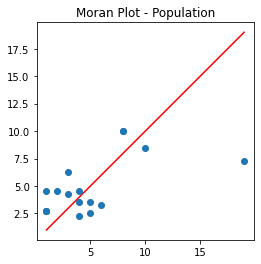

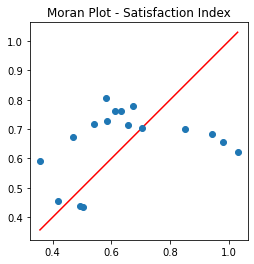

In [8]:
axs = [0,0]
f,axs[0] = plt.subplots(1)
limx,limX = grid_df["pop"].min(), grid_df["pop"].max()
axs[0].plot([limx,limX],[limx,limX],color='red')
axs[0].plot(grid_df["pop"],grid_df["pop_lag"],marker='o',linestyle='none')
axs[0].set_title("Moran Plot - Population")
axs[0].axis("square")


f,axs[1] = plt.subplots(1)

limx,limX = grid_df["satisfied_index"].min(), grid_df["satisfied_index"].max()
axs[1].plot([limx,limX],[limx,limX],color='red')
axs[1].plot(grid_df["satisfied_index"],grid_df["satisfied_index_lag"],marker='o',linestyle='none')
axs[1].set_title("Moran Plot - Satisfaction Index")
axs[1].axis("square")


Existing code * New household data with same parks/grocery*

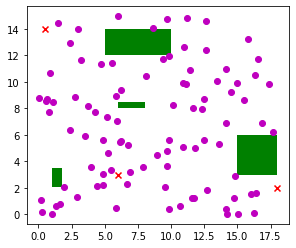

In [17]:
hx = rng.uniform(xedges[0],xedges[-1],100)
hy = rng.uniform(yedges[0],yedges[-1],100)
households = [Point(x, y) for x,y in zip(hx,hy)]

parks = [ box(5, 12, 10, 14) ,box(1, 2.1, 1.8, 3.5),  box(6, 8, 8, 8.5), box(15, 3, 18, 6) ]
grocery =  [Point(18,2), Point(6,3),Point(0.5,14)]


households = [hh.difference(union_all(parks)) for hh in households]
households = [hh for hh in households if not hh.is_empty ]

ax1 = gpd.GeoSeries(parks).plot(color='g')
gpd.GeoSeries(households).plot(ax=ax1,color='m')
gpd.GeoSeries(grocery).plot(ax=ax1,color='r',marker='x')

p = np.array([28.45,35.03,15.03,12.39,5.83,2.03,1.24])/100
p[-1] += 1 - np.sum(p) 
household_size = rng.choice(np.linspace(1,7,7),size=len(households),p=p)

house_df = gpd.GeoDataFrame({'hh_size':household_size, 'geometry': households})
house_df['dist_park'] = house_df.distance(union_all(parks))
house_df['dist_grocery'] = house_df.distance(union_all(grocery))
house_df['satisfied_index'] =  1/(1+house_df['dist_park']) + 1/(1+house_df['dist_grocery'])


In [18]:
len(households)

93

In [16]:
households 

[<POINT (8.629 10.211)>,
 <POINT (9.883 11.514)>,
 <POINT (5.281 1.193)>,
 <POINT (8.218 1.588)>,
 <POINT (0.823 12.83)>,
 <POINT (14.571 5.353)>,
 <POINT (16.335 8.526)>,
 <POINT (13.548 7.553)>,
 <POINT (8.921 9.4)>,
 <POINT (15.188 1.154)>,
 <POINT (0.069 11.547)>,
 <POINT (11.987 1.851)>,
 <POINT (13.813 10.221)>,
 <POINT (5.88 6.032)>,
 <POINT (15.418 7.384)>,
 <POINT (0.003 10.075)>,
 <POINT (11.378 5.565)>,
 <POINT (5.418 0.691)>,
 <POINT (11.315 14.463)>,
 <POINT (4.524 7.84)>,
 <POINT (3.776 11.132)>,
 <POINT (11.271 7.969)>,
 <POINT EMPTY>,
 <POINT (3.371 8.469)>,
 <POINT (15.951 1.841)>,
 <POINT (15.883 9.629)>,
 <POINT (9.892 2.591)>,
 <POINT (12.71 12.355)>,
 <POINT (8.125 10.216)>,
 <POINT (14.426 14.097)>,
 <POINT (15.009 9.436)>,
 <POINT (13.755 3.377)>,
 <POINT (4.377 8.357)>,
 <POINT (0.441 11.577)>,
 <POINT (11.849 10.678)>,
 <POINT (7.403 5.134)>,
 <POINT (16.097 9.83)>,
 <POINT (15.477 14.029)>,
 <POINT (9.608 10.272)>,
 <POINT (6.794 5.51)>,
 <POINT (12.834 13.661

CODE BLOCK 3